In [2]:
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import cv2
import imutils

from tqdm import tqdm

from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms


In [ ]:
#create directory for clean data
os.mkdir(r'data')

### Data Viz

In [3]:
classes = os.listdir(r'data\Training')
classes

['glioma', 'meningioma', 'notumor', 'pituitary']

In [6]:
train_folder = r'rawdata\Training'

In [7]:
# check no. of images in each class
num_imgs_per_class = {}

for tumor_class in os.listdir(train_folder):
    imgs = len(os.listdir(os.path.join(train_folder, tumor_class)))
    num_imgs_per_class[tumor_class] = imgs

print(num_imgs_per_class)

{'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}


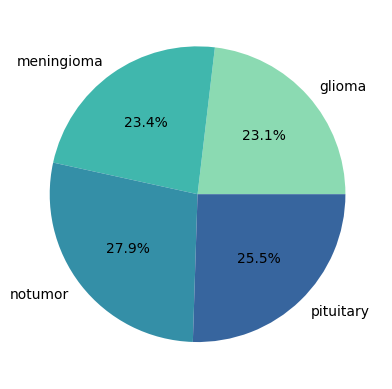

In [8]:
# checking the distribution of the classes
df = pd.DataFrame(num_imgs_per_class.items(), columns=['class', 'count'])

plt.pie(df['count'], labels=list(df['class']), autopct = '%1.1f%%', colors=sns.color_palette('mako_r'))
plt.show()

### segmenting the skull

In [ ]:
def crop_img(image, plot=False):
    # convert to grayscale
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # gaussian blur to clean the smooth edges and clean small noise
    img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)

    # converting img to black-and-white
    # pixel intensities >45 -> 255, rest -> 0
    img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1]

    # erosion + dilation (to clean small white noises)
    img_eroded = cv2.erode(img_thresh, None, iterations=2)
    img_dilated = cv2.dilate(img_eroded, None, iterations=2)

    ### find contours (largest and crop)

    # get outermost contour - USE img_dilated instead of img_thresh
    contours = cv2.findContours(img_dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)

    # select the largest contour (assumption: skull is the largest contour)
    largest_contour = max(contours, key=cv2.contourArea)

    # get extreme points co-ords
    left = tuple(largest_contour[largest_contour[:, :, 0].argmin()][0])
    right = tuple(largest_contour[largest_contour[:, :, 0].argmax()][0])
    top = tuple(largest_contour[largest_contour[:, :, 1].argmin()][0])
    bottom = tuple(largest_contour[largest_contour[:, :, 1].argmax()][0])

    # crop the region
    new_img = image[top[1]:bottom[1], left[0]:right[0]]

    if plot:
        f, ax = plt.subplots(1, 2, figsize=(6, 4))
        ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        ax[1].imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))
        ax[0].set_title('Original')
        ax[1].set_title('Cropped')
        plt.tight_layout()
        plt.show()

    return new_img


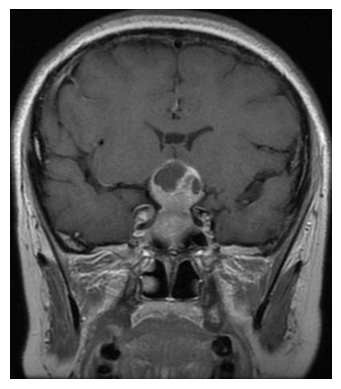

In [82]:
# Load and display
img1 = cv2.imread(r'rawdata\Training\pituitary\Tr-pi_0011.jpg')
cropped = crop_img(img1, False)
plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [83]:
# function to crop all images
def resize_images(start_dir, dest_dir):
    # Collect all jpg files first to get total count
    jpg_files = []
    for root, dir, files in os.walk(start_dir):
        for file in files:
            if file.lower().endswith('jpg'):
                jpg_files.append((root, file))
    
    # Process with progress bar
    for root, file in tqdm(jpg_files, desc="Processing images"):
        src_path = os.path.join(root, file)
        img = cv2.imread(src_path)

        if img is None:
            continue

        cropped_img = crop_img(img)

        # Get relative path (to preserve subfolder structure)
        rel_path = os.path.relpath(root, start_dir)
        save_dir = os.path.join(dest_dir, rel_path)
        os.makedirs(save_dir, exist_ok=True)

        save_path = os.path.join(save_dir, file)
        cv2.imwrite(save_path, cropped_img)

In [84]:
resize_images('rawdata', 'data')

Processing images:   0%|          | 0/7023 [00:00<?, ?it/s]

Processing images: 100%|██████████| 7023/7023 [00:25<00:00, 277.80it/s]


### Data Augmentation

In [9]:
# defining the augmentations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0, 0.2)), # height shift
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [10]:
# create dataset objects
full_train_dataset = datasets.ImageFolder(
    root = 'data/Training',
    transform = train_transform
)

test_dataset = datasets.ImageFolder(
    root='data/Testing',
    transform = test_transform
)

# split Training data into training and validation splits
val_size = int(len(full_train_dataset)* 0.2)
train_size = int(len(full_train_dataset) - val_size)

train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size = 32,
    shuffle=False
)

print(f'Total images in Train folder: {len(full_train_dataset)}')
print(f"|- Training images:   {len(train_dataset)}")
print(f"|- Validation images: {len(val_dataset)}")
print(f"Testing images:    {len(test_dataset)}")

Total images in Train folder: 5712
|- Training images:   4570
|- Validation images: 1142
Testing images:    1311


In [11]:
# checking the indexes
print(full_train_dataset.class_to_idx)
print(test_dataset.class_to_idx)

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [ ]:
# view the real and augemented data

### Model Training